In [ ]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


In [ ]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
!unzip Dataset.zip
!rm Dataset.zip
!unzip ValDataset.zip
!rm ValDataset.zip
Learning_Rate=1e-5
batchSize=32

unzip:  cannot find or open Dataset.zip, Dataset.zip.zip or Dataset.zip.ZIP.
rm: cannot remove 'Dataset.zip': No such file or directory
unzip:  cannot find or open ValDataset.zip, ValDataset.zip.zip or ValDataset.zip.ZIP.
rm: cannot remove 'ValDataset.zip': No such file or directory


## Synthetic images for demo training

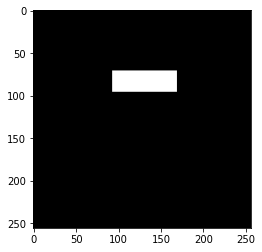

In [ ]:
import os
# assign directory
directory = '/content/content/Dataset/Masks'
 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    img = Image.open("/content/content/Dataset/Masks/0I_0.png")
    
    img = np.array(img)
    #print(img)
    # img = img/255.0
    # img[img > 0.5] = 1.0
    # img[img <= 0.5] = 0.0
    #print(img)
    if img.ndim == 1:
      channels = 1
      print("image has 1 channel")
      print(f)
    plt.imshow(img)
    
    break
    
    # checking if it is a file


In [ ]:
cd ..

/


In [ ]:
rm /content/content/Dataset/Images/111109.jpg

rm: cannot remove '/content/content/Dataset/Images/111109.jpg': No such file or directory


In [ ]:
rm /content/content/Dataset/Masks/111109.jpg

rm: cannot remove '/content/content/Dataset/Masks/111109.jpg': No such file or directory


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
!unzip split_datset.zip

Archive:  split_datset.zip
   creating: content/Augmented_segmentation/
   creating: content/Augmented_segmentation/train/
   creating: content/Augmented_segmentation/train/masks/
  inflating: content/Augmented_segmentation/train/masks/47g_2.png  
  inflating: content/Augmented_segmentation/train/masks/21a_2.png  
  inflating: content/Augmented_segmentation/train/masks/23I_0.png  
  inflating: content/Augmented_segmentation/train/masks/37e_2.png  
  inflating: content/Augmented_segmentation/train/masks/57f_2.png  
  inflating: content/Augmented_segmentation/train/masks/25I_0.png  
  inflating: content/Augmented_segmentation/train/masks/29k_2.png  
  inflating: content/Augmented_segmentation/train/masks/35I_0.png  
  inflating: content/Augmented_segmentation/train/masks/15k2_0.png  
  inflating: content/Augmented_segmentation/train/masks/11k_2.png  
  inflating: content/Augmented_segmentation/train/masks/13f_0.png  
  inflating: content/Augmented_segmentation/train/masks/47g_1.png  
  i

In [ ]:
print(len(os.listdir('/content/content/Dataset/Images')))

801


In [ ]:
import torch
from skimage.io import imread
from torch.utils import data


class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 inputs: list,
                 targets: list,
                 transform=None
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]
        target_ID = self.targets[index]

        # Load input and target
        x, y = imread(input_ID), imread(target_ID, as_gray=True)

        #Comment these three lines if the masks are already binary
        # y = y/255.0
        # y[y > 0.5] = 1.0
        # y[y <= 0.5] = 0.0

        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)
        
        x,y = torch.reshape(x, (3,256,256)) ,torch.reshape(y,(1,256,256))

        return x, y

In [ ]:
import os


def get_inputs_outputs():

# Get the list of all files and directories
  pathi = "/content/content/Dataset/Images/"
  pathm = "/content/content/Dataset/Masks/"
  dir_listi = os.listdir(pathi)
  dir_listm = os.listdir(pathm)
  for i in range(0,len(dir_listi)):
    dir_listi[i] = "/content/content/Dataset/Images/" + dir_listi[i]

  for i in range(0,len(dir_listm)):
    dir_listm[i] = "/content/content/Dataset/Masks/" + dir_listm[i]  

  pathiv = "/content/content/ValDataset/Images/"
  pathmv = "/content/content/ValDataset/Masks/"
  dir_listiv = os.listdir(pathiv)
  dir_listmv = os.listdir(pathmv)
  for i in range(0,len(dir_listiv)):
    dir_listiv[i] = "/content/content/ValDataset/Images/" + dir_listiv[i]

  for i in range(0,len(dir_listmv)):
    dir_listmv[i] = "/content/content/ValDataset/Masks/" + dir_listmv[i]   
  return dir_listi, dir_listm, dir_listiv, dir_listmv  

In [ ]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [ ]:
import os

if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/usuyama/pytorch-unet.git

  %cd pytorch-unet

In [ ]:
%cd pytorch-unet

[Errno 2] No such file or directory: 'pytorch-unet'
/content/pytorch-unet


In [ ]:
!ls

helper.py  __pycache__			pytorch_unet.py
images	   pytorch_fcn.ipynb		pytorch_unet_resnet18_colab.ipynb
LICENSE    pytorch_resnet18_unet.ipynb	README.md
loss.py    pytorch_unet.ipynb		simulation.py


In [ ]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

checkpoint_path = "/content/checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25,batch_size=1):
    best_loss = 1e10
    model.load_state_dict(torch.load(checkpoint_path))

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #labels = torch.reshape(labels,(batch_size,1,256,256))
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels.float(), metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    #model.load_state_dict(torch.load(checkpoint_path))
    return model

## Training

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)
from torch.utils.data import Dataset, DataLoader
net = UNET(3,1)
net = net.to(device)
bs = 16

lossfn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),0.001)
inputs, outputs, inputsv, outputsv = get_inputs_outputs()
training_dataset = SegmentationDataSet(inputs=inputs,
                                    targets=outputs,
                                    transform=None)
validation_dataset = SegmentationDataSet(inputs=inputsv,
                                    targets=outputsv,
                                    transform=None)



# training_dataloader = data.DataLoader(dataset=training_dataset,
#                                   batch_size=1,
#                                   shuffle=True)
# validation_dataloader = data.DataLoader(dataset=validation_dataset,
#                                   batch_size=1,
#                                   shuffle=True)
dataloaders = {
  'train': DataLoader(dataset=training_dataset,
                                  batch_size=32,
                                  shuffle=True, num_workers=0),
  'val': DataLoader(dataset=validation_dataset,
                                  batch_size=32,
                                  shuffle=True, num_workers=0)
}

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(net, optimizer_ft, exp_lr_scheduler, num_epochs=100,batch_size=bs)
# train_loss, valid_loss = train(net,training_dataloader,validation_dataloader ,lossfn, opt, acc_metric,epochs= 10)

device cuda
Epoch 0/99
----------
train: bce: 0.581081, dice: 0.919481, loss: 0.750281
LR 0.0001
val: bce: 0.580588, dice: 0.919573, loss: 0.750081
saving best model to /content/checkpoint.pth
0m 11s
Epoch 1/99
----------
train: bce: 0.578210, dice: 0.919252, loss: 0.748731
LR 0.0001
val: bce: 0.579954, dice: 0.919059, loss: 0.749506
saving best model to /content/checkpoint.pth
0m 11s
Epoch 2/99
----------
train: bce: 0.575247, dice: 0.919000, loss: 0.747124
LR 0.0001
val: bce: 0.577035, dice: 0.918854, loss: 0.747944
saving best model to /content/checkpoint.pth
0m 11s
Epoch 3/99
----------
train: bce: 0.572699, dice: 0.918683, loss: 0.745691
LR 0.0001
val: bce: 0.573831, dice: 0.918790, loss: 0.746310
saving best model to /content/checkpoint.pth
0m 11s
Epoch 4/99
----------
train: bce: 0.569637, dice: 0.918567, loss: 0.744102
LR 0.0001
val: bce: 0.571388, dice: 0.918923, loss: 0.745155
saving best model to /content/checkpoint.pth
0m 11s
Epoch 5/99
----------
train: bce: 0.566906, dice

In [ ]:
# create data
ep= [i for i in range(1,26)]
bce_t = [0.736492,]
dic_t = []
bce_v = []
dic_v = []

  
# plot lines
plt.plot(ep, bce_t, label = "Train")
plt.plot(ep, bce_v, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(ep, dic_t, label = "Train")
plt.plot(ep, dic_v, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.show()